### Imports

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import plotly.express as px
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

### Reading .csv, shuffling rows, renaming columns 
Input .csv file is a mix of parsed .pcap traffic files, so at first we need to preprocess our data

In [68]:
df = pd.read_csv('test_allinone_bigger.csv')
df = df.dropna()  #dropping NaN rows
df = df.sample(frac = 0.15, random_state = 1)  #getting random 15% from our data (near 150k rows)
df = df.rename(columns={"Timestamp": "timestamps", "Length": "sizes", "Filename":"file_names"}) 
df

,Id,sizes,timestamps,SrcAddress,SrcPort,DestAddress,DestPort,file_names
707933,707933,154,1.563294e+09,10.123.1.2,1195.0,10.123.1.1,1195.0,vpn_netflix_capture2.pcap
202281,202281,1482,1.563294e+09,10.123.1.1,1195.0,10.123.1.2,1195.0,vpn_netflix_capture2.pcap
489008,489008,154,1.563293e+09,10.123.1.2,1195.0,10.123.1.1,1195.0,vpn_netflix_capture2.pcap
597487,597487,154,1.563293e+09,10.123.1.2,1195.0,10.123.1.1,1195.0,vpn_netflix_capture2.pcap
756983,756983,1482,1.563294e+09,10.123.1.1,1195.0,10.123.1.2,1195.0,vpn_netflix_capture2.pcap
...,...,...,...,...,...,...,...,...
394628,394628,298,1.561118e+09,10.105.1.1,1195.0,10.105.1.2,1195.0,vpn_rdp_capture2.pcap
290931,290931,650,1.563294e+09,10.123.1.1,1195.0,10.123.1.2,1195.0,vpn_netflix_capture2.pcap
820621,820621,1378,1.561647e+09,10.115.1.123,22.0,10.113.1.150,45052.0,nonvpn_sftp_capture3.pcap
698247,698247,1482,1.563294e+09,10.123.1.1,1195.0,10.123.1.2,1195.0,vpn_netflix_capture2.pcap


We don't need all columns for classification, so let's drop them

In [69]:
df = df.drop(columns=['Id', 'SrcAddress', 'SrcPort', 'DestAddress', 'DestPort'])
df

,sizes,timestamps,file_names
707933,154,1.563294e+09,vpn_netflix_capture2.pcap
202281,1482,1.563294e+09,vpn_netflix_capture2.pcap
489008,154,1.563293e+09,vpn_netflix_capture2.pcap
597487,154,1.563293e+09,vpn_netflix_capture2.pcap
756983,1482,1.563294e+09,vpn_netflix_capture2.pcap
...,...,...,...
394628,298,1.561118e+09,vpn_rdp_capture2.pcap
290931,650,1.563294e+09,vpn_netflix_capture2.pcap
820621,1378,1.561647e+09,nonvpn_sftp_capture3.pcap
698247,1482,1.563294e+09,vpn_netflix_capture2.pcap


### Parsing file names and splitting them to categories and applications for future testing
Every row of dataset has a file name which includes name of application and vpn/nonvpn status. Let's parse it into different classes so we can train classification models on it

#### Category names and numbers:
1 - Streaming

2 - Chat

3 - Command and Control

4 - File Transfer

#### Applications names and numbers:
1 - youtube

2 - netflix

3 - skype

4 - ssh

5 - rdp

6 - sftp

7 - rsync

8 - scp

#### (duct tape part below, need to fix this)

In [70]:
category, application, isvpn, cat_num, app_num, keys = [],[],[],[],[],[]


for i in df['file_names']:
    i = str(i)
    if i.find('youtube') != -1:
        category.append('Streaming')
        cat_num.append('1')
        app_num.append('1')
        application.append('youtube')
    elif i.find('netflix') != -1:
        category.append('Streaming')
        cat_num.append('1')
        app_num.append('2')
        application.append('netflix')
    elif i.find('skype-chat') != -1:
        category.append('Chat')
        cat_num.append('2')
        app_num.append('3')
        application.append('skype')
    elif i.find('ssh') != -1:
        category.append('Command and control')
        cat_num.append('3')
        app_num.append('4')
        application.append('ssh')
    elif i.find('rdp') != -1:
        category.append('Command and control')
        cat_num.append('3')
        app_num.append('5')
        application.append('rdp')
    elif i.find('sftp') != -1:
        category.append('File transfer')
        cat_num.append('4')
        app_num.append('6')
        application.append('sftp')
    elif i.find('rsync') != -1:
        category.append('File transfer')
        cat_num.append('4')
        app_num.append('7')
        application.append('rsync')
    elif i.find('scp') != -1:
        category.append('File transfer')
        cat_num.append('4')
        app_num.append('8')
        application.append('scp')
    else:
        category.append('0')
        application.append('0')
        cat_num.append('0')
        app_num.append('0')

    
    if i.find('nonvpn'): isvpn.append('nonvpn')
    elif i.find('vpn'): isvpn.append('vpn')
    else: isvpn.append('0')

### Adding new columns to dataset

In [71]:
df_fin = df.assign(category=category, application=application, isvpn=isvpn,
                        category_number = cat_num, application_number=app_num)

In [72]:
df_fin

,sizes,timestamps,file_names,category,application,isvpn,category_number,application_number
707933,154,1.563294e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
202281,1482,1.563294e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
489008,154,1.563293e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
597487,154,1.563293e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
756983,1482,1.563294e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
...,...,...,...,...,...,...,...,...
394628,298,1.561118e+09,vpn_rdp_capture2.pcap,Command and control,rdp,nonvpn,3,5
290931,650,1.563294e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2
820621,1378,1.561647e+09,nonvpn_sftp_capture3.pcap,File transfer,sftp,vpn,4,6
698247,1482,1.563294e+09,vpn_netflix_capture2.pcap,Streaming,netflix,nonvpn,1,2


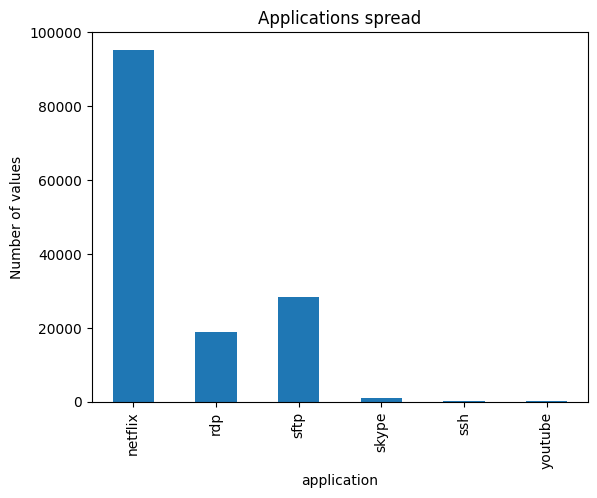

In [73]:
df_fin.groupby('application').sizes.count().plot.bar()
ax = plt.subplot()
ax.set_ylabel('Number of values')
ax.set_title('Applications spread')
plt.show()

#text interpretation:
#df_fin[['application']].value_counts()

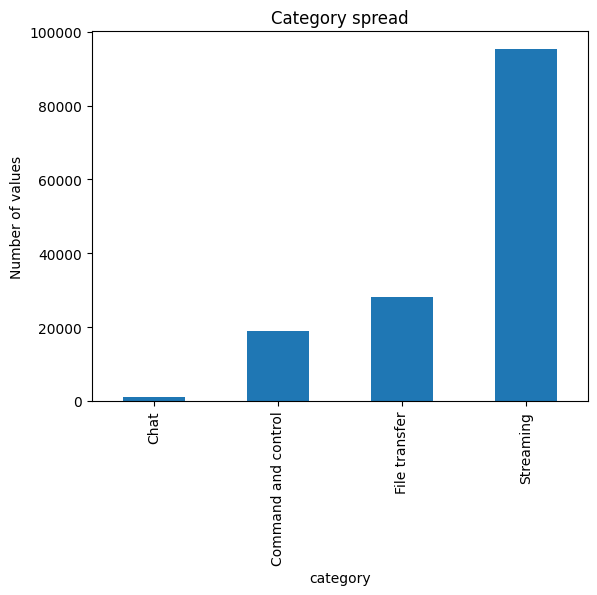

In [74]:
df_fin.groupby('category').sizes.count().plot.bar()
ax = plt.subplot()
ax.set_ylabel('Number of values')
ax.set_title('Category spread')
plt.show()

### Oversampling imbalanced data
As we can see above, our data is very imbalanced. One of the ways to solve this problem is to use oversampling techniques, which refers to copying or synthesizing new examples of the minority classes so that the number of examples in the minority class better resembles or matches the number of examples in the majority classes. 

We will use SMOTE technique (Synthetic Minority Oversampling Technique) to do this.

Also, we need need to split our data on training and testing data, which we'll use to train models to predict category and apllication type of every file.

In [76]:
X_cat = df_fin[['timestamps','sizes']]
y_cat = df_fin.category_number

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size = 0.2, stratify = y_cat)

print("y_train count before oversampling:\n", y_train_cat.value_counts())

sm = SMOTE(k_neighbors=5, sampling_strategy='not majority')
X_train_cat_res, y_train_cat_res = sm.fit_resample(X_train_cat, y_train_cat)

print("y_train count after oversampling with SMOTE:\n", y_train_cat_res.value_counts())

y_train count before oversampling:
 1    76281
4    22572
3    15133
2      782
Name: category_number, dtype: int64
y_train count after oversampling with SMOTE:
 1    76281
3    76281
4    76281
2    76281
Name: category_number, dtype: int64


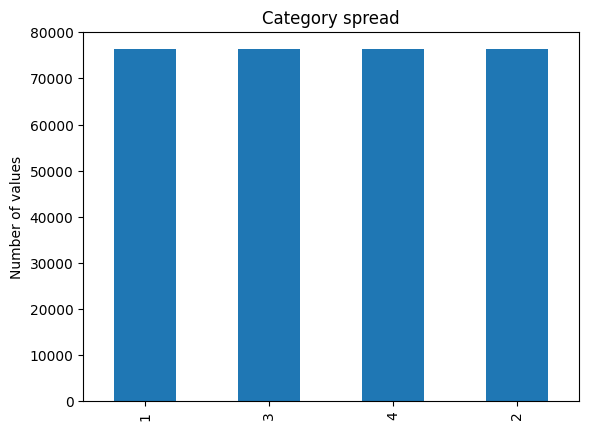

In [78]:
y_train_cat_res.value_counts().plot.bar()
ax = plt.subplot()
ax.set_ylabel('Number of values')
ax.set_title('Balanced category spread')
plt.show()

As we can see, our training data is now balanced. Let's do the same thing for application prediction data:

In [80]:
X_ap = df_fin[['timestamps','sizes']]
y_ap = df_fin.application_number

X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_ap, y_ap, test_size = 0.2)

print("y_train count before oversampling:\n", y_train_ap.value_counts())

sm = SMOTE(k_neighbors=5, sampling_strategy='not majority')
X_train_ap_res, y_train_ap_res = sm.fit_resample(X_train_ap, y_train_ap)

print("y_train count after oversampling with SMOTE:\n", y_train_ap_res.value_counts())

y_train count before oversampling:
 2    76094
6    22637
5    15035
3      805
4      131
1       66
Name: application_number, dtype: int64
y_train count after oversampling with SMOTE:
 2    76094
5    76094
6    76094
3    76094
1    76094
4    76094
Name: application_number, dtype: int64


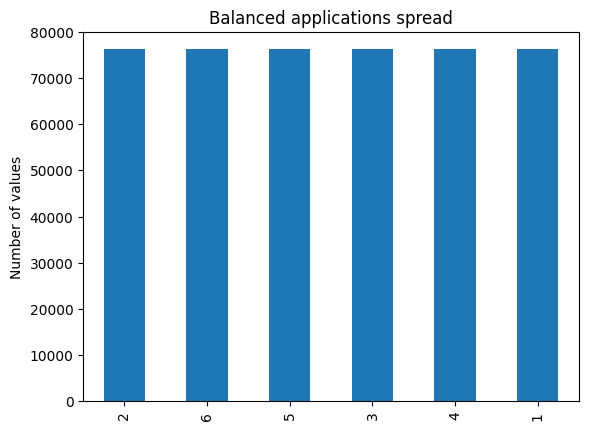

In [79]:
y_train_ap_res.value_counts().plot.bar()
ax = plt.subplot()
ax.set_ylabel('Number of values')
ax.set_title('Balanced applications spread')
plt.show()

Now our training data is oversampled, so we are ready to fit classification models

### Training models
(Using AdaBoost classifier and oversampled training data)

In [81]:
ada_cat = AdaBoostClassifier()
ada_cat.fit(X_train_cat_res, y_train_cat_res)

AdaBoostClassifier()

In [82]:
ada_ap = AdaBoostClassifier()
ada_ap.fit(X_train_ap_res, y_train_ap_res)

AdaBoostClassifier()

### Training results for category prediction

In [83]:
ada_pred_proba_cat = ada_cat.predict_proba(X_test_cat)
ada_pred_cat = ada_cat.predict(X_test_cat)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_cat, ada_pred_proba_cat, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_cat, ada_pred_cat, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_cat, ada_pred_cat))

roc auc score for Category prediction:
 0.9880341880341881

f1 score for Category prediction:
 0.9989876197822257

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     19071
           2       1.00      0.86      0.92       195
           3       1.00      1.00      1.00      3784
           4       1.00      1.00      1.00      5643

    accuracy                           1.00     28693
   macro avg       1.00      0.96      0.98     28693
weighted avg       1.00      1.00      1.00     28693



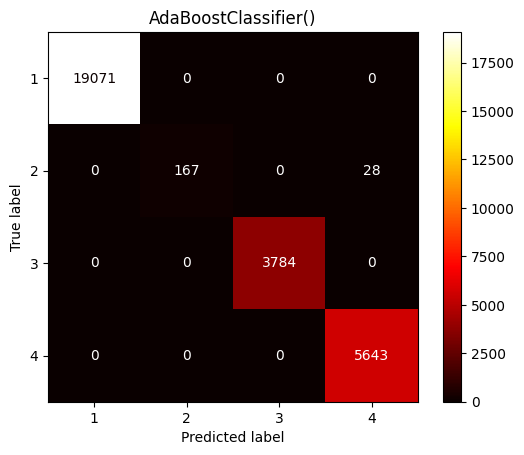

In [84]:
ConfusionMatrixDisplay.from_estimator(ada_cat, X_test_cat, y_test_cat, cmap='hot')
plt.title(ada_cat)
plt.show()

### Hyperparameter Tuning with Grid Search
Adaboost score is already near perfect, but we can make it even better with hyperparameter tuning.

In [42]:
params = { 'n_estimators': [10, 30, 50], 'learning_rate':[0.1, 0.5, 0.8]}

grid = GridSearchCV(ada_cat, params, cv = 5, n_jobs = -1)
grid.fit(X_train_cat_res, y_train_cat_res)

grid.best_params_

{'learning_rate': 0.5, 'n_estimators': 10}

In [43]:
ada_cat = AdaBoostClassifier(n_estimators = 10, learning_rate = 0.5)
ada_cat.fit(X_train_cat_res, y_train_cat_res)


ada_pred_proba_cat = ada_cat.predict_proba(X_test_cat)
ada_pred_cat = ada_cat.predict(X_test_cat)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_cat, ada_pred_proba_cat, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_cat, ada_pred_cat, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_cat, ada_pred_cat))

roc auc score for Category prediction:
 1.0

f1 score for Category prediction:
 1.0

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     19071
           2       1.00      1.00      1.00       195
           3       1.00      1.00      1.00      3784
           4       1.00      1.00      1.00      5643

    accuracy                           1.00     28693
   macro avg       1.00      1.00      1.00     28693
weighted avg       1.00      1.00      1.00     28693



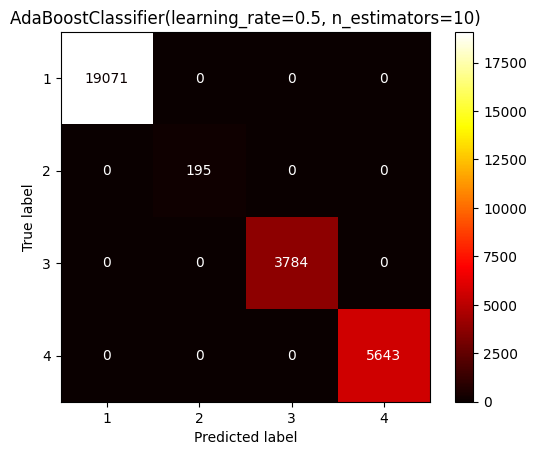

In [44]:
ConfusionMatrixDisplay.from_estimator(ada_cat, X_test_cat, y_test_cat, cmap='hot')
plt.title(ada_cat)
plt.show()

### Training results for applications prediction

In [240]:
ada_pred_proba_ap = ada_ap.predict_proba(X_test_ap)
ada_pred_ap = ada_ap.predict(X_test_ap)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_ap, ada_pred_proba_ap, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_ap, ada_pred_ap, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_ap, ada_pred_ap, zero_division=0))

roc auc score for Category prediction:
 0.953968253968254

f1 score for Category prediction:
 0.9921477348915114

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00     38241
           3       0.00      0.00      0.00       378
           4       0.17      1.00      0.29        69
           5       1.00      1.00      1.00      7525
           6       1.00      1.00      1.00     11136

    accuracy                           0.99     57385
   macro avg       0.69      0.83      0.72     57385
weighted avg       0.99      0.99      0.99     57385



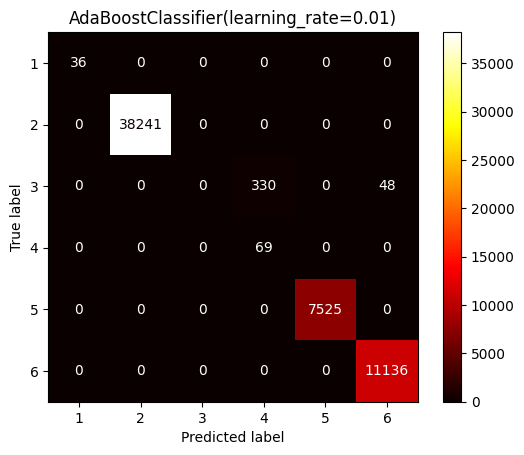

In [227]:
ConfusionMatrixDisplay.from_estimator(ada_ap, X_test_ap, y_test_ap, cmap='hot')
plt.title(ada_ap)
plt.show()

### Hyperparameter Tuning for application prediction

In [85]:
params = { 'n_estimators': [10, 30, 50], 'learning_rate':[0.01, 0.1, 0.2]}

grid = GridSearchCV(ada_ap, params, cv = 5, n_jobs = -1)
grid.fit(X_train_ap_res, y_train_ap_res)

grid.best_params_

{'learning_rate': 0.01, 'n_estimators': 10}

In [87]:
ada_ap = AdaBoostClassifier(n_estimators = 10, learning_rate = 0.01)
ada_ap.fit(X_train_ap_res, y_train_ap_res)

ada_pred_proba_ap = ada_ap.predict_proba(X_test_ap)
ada_pred_ap = ada_ap.predict(X_test_ap)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_ap, ada_pred_proba_ap, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_ap, ada_pred_ap, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_ap, ada_pred_ap, zero_division=0))

roc auc score for Category prediction:
 0.9532945736434109

f1 score for Category prediction:
 0.9928601436108505

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00     19174
           3       0.00      0.00      0.00       172
           4       0.17      1.00      0.29        30
           5       1.00      1.00      1.00      3721
           6       1.00      1.00      1.00      5578

    accuracy                           0.99     28693
   macro avg       0.69      0.83      0.71     28693
weighted avg       0.99      0.99      0.99     28693



Not perfect, but still very good results.

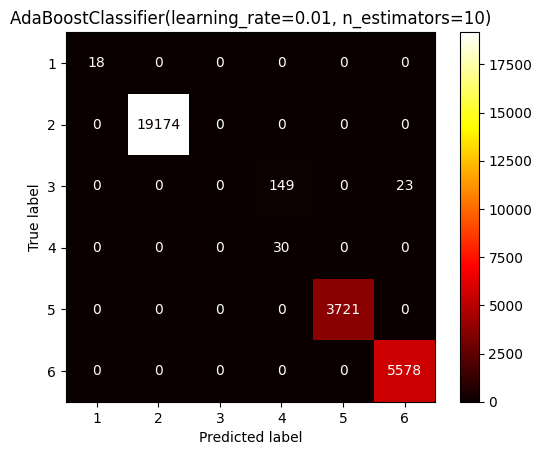

In [88]:
ConfusionMatrixDisplay.from_estimator(ada_ap, X_test_ap, y_test_ap, cmap='hot')
plt.title(ada_ap)
plt.show()

### Cost-sensitive learning for classification
Most machine learning algorithms assume that all classes have an equal number of examples.

This is not the case in multi-class imbalanced classification. Some algorithms can be modified to change the way learning is performed to bias towards those classes that have fewer examples in the training dataset.

For example, we can use Random forest classifier.

In [61]:
forest_cat = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
forest_cat.fit(X_train_cat, y_train_cat)

RandomForestClassifier(class_weight='balanced')

In [64]:
forest_ap = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
forest_ap.fit(X_train_ap, y_train_ap)

RandomForestClassifier(class_weight='balanced')

### Training results for category prediction

In [59]:
forest_pred_proba_cat = forest_cat.predict_proba(X_test_cat)
forest_pred_cat = forest_cat.predict(X_test_cat)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_cat, forest_pred_proba_cat, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_cat, forest_pred_cat, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_cat, forest_pred_cat, zero_division=0))

roc auc score for Category prediction:
 1.0

f1 score for Category prediction:
 1.0

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     19071
           2       1.00      1.00      1.00       195
           3       1.00      1.00      1.00      3784
           4       1.00      1.00      1.00      5643

    accuracy                           1.00     28693
   macro avg       1.00      1.00      1.00     28693
weighted avg       1.00      1.00      1.00     28693



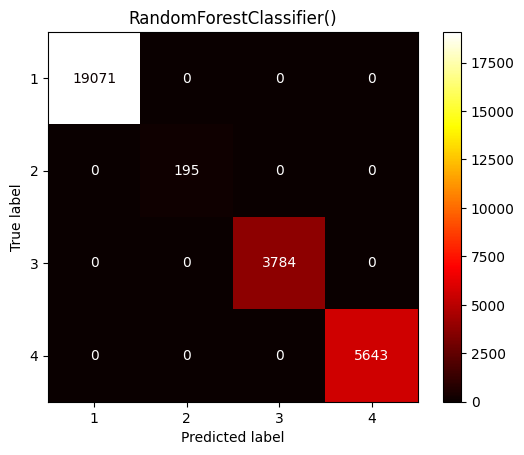

In [60]:
ConfusionMatrixDisplay.from_estimator(forest_cat, X_test_cat, y_test_cat, cmap='hot')
plt.title(forest_cat)
plt.show()

### Training results for application prediction

In [65]:
forest_pred_proba_ap = forest_ap.predict_proba(X_test_ap)
forest_pred_ap = forest_ap.predict(X_test_ap)
print("roc auc score for Category prediction:\n", 
      roc_auc_score(y_test_ap, forest_pred_proba_ap, multi_class='ovo'))
print("\nf1 score for Category prediction:\n",
      f1_score(y_test_ap, forest_pred_ap, average='weighted'))

print("\nclassification report:\n", classification_report(y_test_ap, forest_pred_ap, zero_division=0))

roc auc score for Category prediction:
 1.0

f1 score for Category prediction:
 1.0

classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00     19091
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00      3660
           6       1.00      1.00      1.00      5687

    accuracy                           1.00     28693
   macro avg       1.00      1.00      1.00     28693
weighted avg       1.00      1.00      1.00     28693



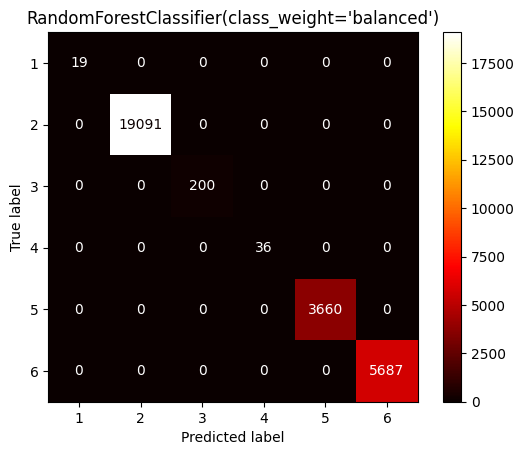

In [66]:
ConfusionMatrixDisplay.from_estimator(forest_ap, X_test_ap, y_test_ap, cmap='hot')
plt.title(forest_ap)
plt.show()